In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
nycrime = pd.read_csv('./NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013 - 13tbl8ny.csv',thousands=',')

In [3]:
nycrime.columns

Index(['City', 'Population', 'Violentcrime', 'Murder', 'Raperevised',
       'Rapelegacy', 'Robbery', 'Aggravatedassault', 'Propertycrime',
       'Burglary', 'Larceny-theft', 'Motorvehicletheft', 'Arson3'],
      dtype='object')

In [4]:
nycrime_df = nycrime[['Propertycrime','Population','Murder','Robbery']]

In [5]:
nycrime_df = nycrime_df.astype(float)

In [6]:
nycrime_df.dtypes

Propertycrime    float64
Population       float64
Murder           float64
Robbery          float64
dtype: object

In [7]:
nycrime_df['City'] = nycrime['City']

In [8]:
nycrime_df['popsq'] = nycrime_df['Population']**2
nycrime_df['Robberies'] = np.where(nycrime_df['Robbery']>0,1,0)
nycrime_df['Murders'] = np.where(nycrime_df['Murder']>0,1,0)

In [9]:
nycrime_df.head()

,Propertycrime,Population,Murder,Robbery,City,popsq,Robberies,Murders
0,12.000,1861.000,0.000,0.000,Adams Village,3463321.000,0,0
1,24.000,2577.000,0.000,0.000,Addison Town and Village,6640929.000,0,0
2,16.000,2846.000,0.000,0.000,Akron Village,8099716.000,0,0
3,4090.000,97956.000,8.000,227.000,Albany,9595377936.000,1,1
4,223.000,6388.000,0.000,4.000,Albion Village,40806544.000,1,0


In [10]:
nycrime_df.iloc[216,:]

Propertycrime           141971.000
Population             8396126.000
Murder                     335.000
Robbery                  19170.000
City                      New York
popsq           70494931807876.000
Robberies                        1
Murders                          1
Name: 216, dtype: object

* New York City is in general a huge outlier which should probably be handled outside of a single regression model.

* Easy thing to do is to exclude it for now.

* We develop a crime regression model without NYC for now to minimize the degrading effects on prediction it would likely cause.


In [11]:
nycrime_df = nycrime_df[nycrime_df.City != 'New York']

In [12]:
# fit an initial model
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = nycrime_df['Propertycrime'].values.reshape(-1, 1)
X = nycrime_df[['Population','Murder','Robbery', 'popsq','Robberies','Murders']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.18596504e-02  1.14598492e+02  4.91914164e+00 -7.89196974e-08
   4.66937934e+01 -1.67402643e+02]]

Intercept: 
 [-47.33196358]

R-squared:
0.9414674090958225


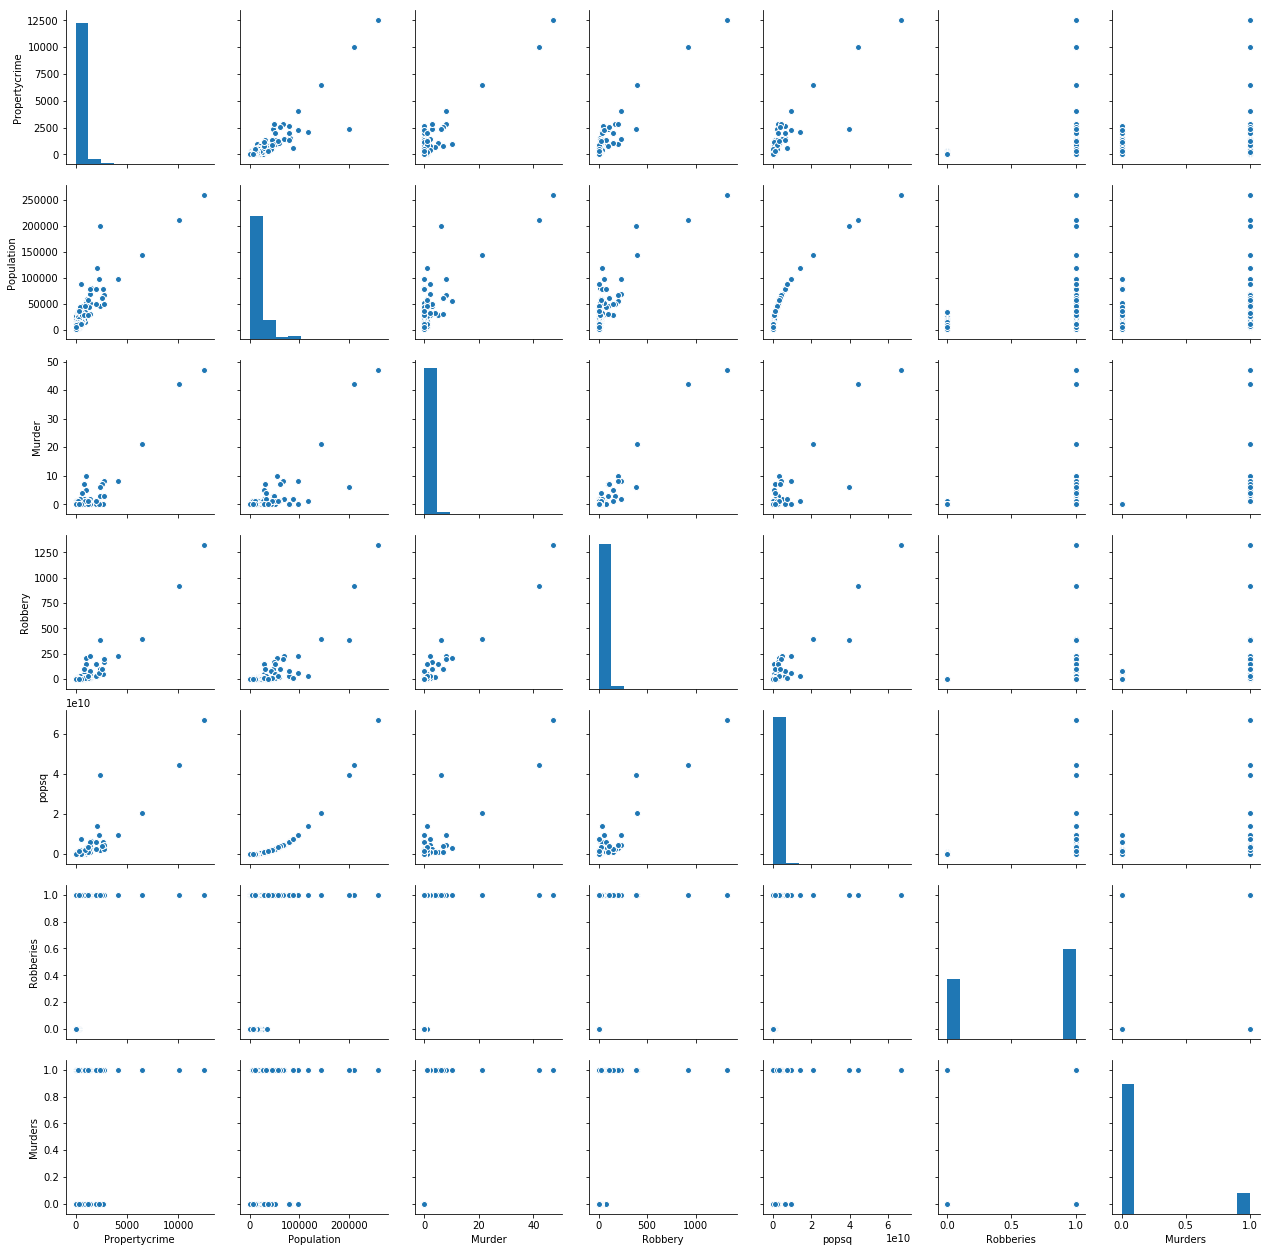

In [13]:
sns.pairplot(nycrime_df)

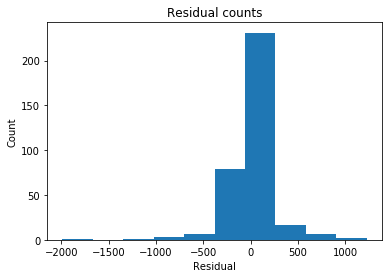

In [14]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = nycrime_df['Propertycrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

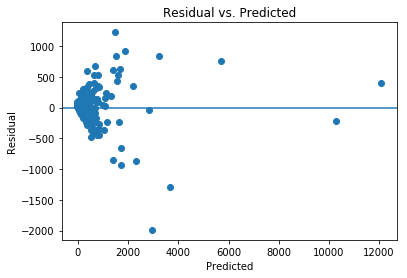

In [15]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

* Let's add some interaction terms with Robberies , Murders etc.

* Also we should look into log transforming Propertycrime as errors are not homoskedastic from residual plot.

In [16]:
#nycrime_df['logPropertycrime'] = np.log(nycrime_df['Propertycrime'] + 1)
#nycrime_df['Rob*robberies'] = nycrime_df["Robberies"]*nycrime_df['Robbery']
#nycrime_df['Murd*murders'] = nycrime_df["Murders"]*nycrime_df['Murder']
nycrime_df['bigMurder'] = np.where(nycrime_df['Murder']>20,1,0)
nycrime_df['bigRob'] = np.where(nycrime_df['Robbery'] > 400,1,0)
nycrime_df['midRob'] = np.where((nycrime_df['Robbery'] < 400) & (nycrime_df['Robbery'] > 100),1,0)
nycrime_df['lowPop'] = np.where((nycrime_df['Population'] < 150000),1,0)
nycrime_df['midMurd'] = np.where((nycrime_df['Murder'] < 15) & (nycrime_df['Murder'] > 5),1,0)
nycrime_df['lowPop*murder'] =nycrime_df["lowPop"]*nycrime_df['Murder']
nycrime_df['lowPop*rob'] =nycrime_df["lowPop"]*nycrime_df['Murder']

In [18]:
# fit an initial model
# Instantiate and fit our model.
regr1 = linear_model.LinearRegression()
Y1 = nycrime_df['Propertycrime'].values.reshape(-1, 1)
X1 = nycrime_df[['Population','Murder','Robbery', 'popsq','bigMurder','bigRob','lowPop',
                 'midMurd','midRob','Robberies','Murders','lowPop*murder','lowPop*rob']]
regr1.fit(X1, Y1)

# Inspect the results.
print('\nCoefficients: \n', regr1.coef_)
print('\nIntercept: \n', regr1.intercept_)
print('\nR-squared:')
print(regr1.score(X1, Y1))


Coefficients: 
 [[ 1.45668516e-02 -1.19204011e+02  3.65554927e+00  3.78456519e-08
   5.75744589e+03  5.85298185e+03  4.94597925e+03  1.10439106e+03
   8.05488460e+02  8.39149268e+01  2.27982249e+02 -3.36595026e+01
  -3.36595026e+01]]

Intercept: 
 [-4965.7361382]

R-squared:
0.9617447843940394


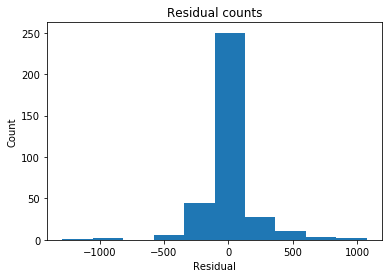

In [19]:
# Extract predicted values.
predicted = regr1.predict(X1).ravel()
actual = nycrime_df['Propertycrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

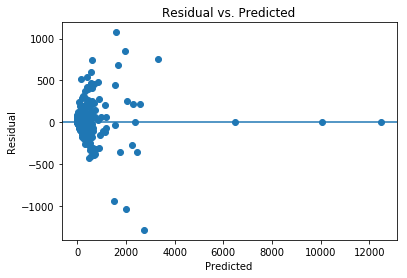

In [20]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

* Have added a number of dummy variables

* Examples are for low population, high rates of murder and robbery and medium levels of robbery and murder.

* I have added in interaction variables between lowPop and Murder and Robbery.

* Log transformation and square root transformation of the continuous variables decreased R^2.